Loading data

In [1]:
import re

# Load the book's text
with open('data/TKMBFullBook.txt', 'r', encoding='utf-8') as f:
    text = f.read()

Cleaing book by spliting the chapters

In [2]:
chapters = re.split(r'Chapter \d+', text)
if chapters[0].strip() == "":
    chapters.pop(0) # Remove the empty string before the first chapter

Tokenizing by sentences and chunking by paragraphs

In [3]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def sentence_chunks(text, tokenizer, max_tokens=450, overlap_tokens=60):
    """
    Greedy pack sentences into chunks under max_tokens using the model tokenizer.
    Adds a small sentence-level overlap between adjacent chunks using tokens.
    """
    sents = sent_tokenize(text)
    chunks = []
    current = []
    current_tokens = 0

    def tok_len(t):
        return len(tokenizer.tokenize(t))

    i = 0
    while i < len(sents):
        s = sents[i]
        s_tokens = tok_len(s)
        if s_tokens > max_tokens:
            # Very long sentence: hard split by words as a rare fallback
            words = s.split()
            # keep ~max_tokens-10 tokens margin when splitting
            step = max(1, int(len(words) * (max_tokens / (s_tokens + 1e-9))))
            for wstart in range(0, len(words), step):
                piece = " ".join(words[wstart:wstart+step])
                chunks.append(piece)
            i += 1
            current, current_tokens = [], 0
            continue

        if current_tokens + s_tokens <= max_tokens:
            current.append(s)
            current_tokens += s_tokens
            i += 1
        else:
            # finalize current chunk
            if current:
                chunk_text = " ".join(current)
                chunks.append(chunk_text)

                # build overlap buffer from the end of current
                if overlap_tokens > 0:
                    back = []
                    back_tokens = 0
                    for sent in reversed(current):
                        tl = tok_len(sent)
                        if back_tokens + tl > overlap_tokens:
                            break
                        back.append(sent)
                        back_tokens += tl
                    current = list(reversed(back))
                    current_tokens = sum(tok_len(x) for x in current)
                else:
                    current, current_tokens = [], 0
            else:
                # edge case: single sentence larger than budget handled above
                i += 1

    if current:
        chunks.append(" ".join(current))

    return chunks


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\salij\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Initializing SPLADE model

In [4]:
from sentence_transformers import SparseEncoder, SimilarityFunction

model = SparseEncoder(
    "naver/splade-cocondenser-ensembledistil"
    #similarity_fn_name=SimilarityFunction.COSINE,
)

W0830 05:54:07.037000 2452 torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Initializinf SPLADE Tokenizer

In [5]:
tokenizer = model.tokenizer

Tokenizing with SPLADE Tokenizer

In [6]:
all_chunks = []
for chap_num, chap_text in enumerate(chapters, start=1):
    for i, chunk in enumerate(sentence_chunks(chap_text, tokenizer,
                                              max_tokens=450, overlap_tokens=60), start=1):
        all_chunks.append({
            "chapter": chap_num,
            "chunk_id": f"{chap_num}_{i}",
            "text": chunk
        })

In [29]:
print(f"Total chunks created: {len(all_chunks)}")
print(f"Example chunk: {all_chunks[72]}")

Total chunks created: 369
Example chunk: {'chapter': 7, 'chunk_id': '7_1', 'text': '\n Jem stayed moody and silent for a week. As Atticus had once advised me to do, I \ntried to climb into Jem’s skin and walk around in it: if I had gone alone to the \nRadley Place at two in the morning, my funeral would have been held the next \nafternoon. So I left Jem alone and tried not to bother him. School started. The second grade was as bad as the first, only worse—they still \nflashed cards at you and wouldn’t let you read or write. Miss Caroline’s progress \nnext door could be estimated by the frequency of laughter; however, the usual \ncrew had flunked the first grade again, and were helpful in keeping order. The \nonly thing good about the second grade was that this year I had to stay as late as \nJem, and we usually walked home together at three o’clock. One afternoon when we were crossing the schoolyard toward home, Jem suddenly \nsaid: “There’s something I didn’t tell you.”\n As this was 

Creating SPLADE Embeddings

In [8]:
texts = [chunk['text'] for chunk in all_chunks]
embeddings = model.encode(texts, convert_to_tensor=True, show_progress_bar=True, batch_size=32)

Batches: 100%|██████████| 12/12 [02:06<00:00, 10.51s/it]


In [9]:
embeddings[1]  # Example to show the embedding of the second chunk

tensor(indices=tensor([[ 1005,  1055,  1521,  2001,  2002,  2006,  2010,  2015,
                         2016,  2018,  2020,  2026,  2027,  2031,  2037,  2056,
                         2061,  2082,  2089,  2093,  2110,  2138,  2141,  2148,
                         2150,  2155,  2158,  2160,  2167,  2171,  2173,  2210,
                         2221,  2237,  2239,  2240,  2253,  2264,  2269,  2271,
                         2273,  2287,  2299,  2314,  2315,  2318,  2320,  2331,
                         2333,  2351,  2352,  2358,  2359,  2375,  2424,  2436,
                         2438,  2444,  2455,  2466,  2479,  2496,  2511,  2513,
                         2529,  2542,  2562,  2563,  2564,  2567,  2604,  2631,
                         2632,  2661,  2682,  2684,  2709,  2722,  2743,  2815,
                         2817,  2835,  2905,  2945,  2973,  2990,  2994,  3002,
                         3008,  3039,  3060,  3079,  3182,  3191,  3210,  3218,
                         3256,  3268,  3

In [10]:
#Shape of embeddings
print(f"Number of embeddings: {len(embeddings)}")
print(f"Embedding dimension: {len(embeddings[0])}")

Number of embeddings: 369
Embedding dimension: 30522


In [11]:
embeddings[0]

tensor(indices=tensor([[ 1045,  1997,  2001,  2002,  2010,  2012,  2013,  2018,
                         2020,  2021,  2025,  2026,  2031,  2032,  2034,  2039,
                         2040,  2041,  2043,  2052,  2055,  2056,  2057,  2061,
                         2065,  2067,  2077,  2081,  2084,  2086,  2094,  2106,
                         2108,  2113,  2119,  2121,  2126,  2131,  2134,  2138,
                         2140,  2141,  2146,  2147,  2148,  2150,  2155,  2157,
                         2158,  2170,  2176,  2187,  2192,  2196,  2198,  2209,
                         2214,  2217,  2220,  2224,  2234,  2236,  2253,  2256,
                         2257,  2269,  2271,  2272,  2277,  2287,  2288,  2298,
                         2299,  2318,  2347,  2351,  2354,  2359,  2360,  2365,
                         2370,  2374,  2377,  2394,  2398,  2404,  2408,  2409,
                         2410,  2428,  2448,  2460,  2466,  2499,  2501,  2518,
                         2521,  2545,  2

Calling OpenAPI GPT model for text generation

In [12]:
import openai
from openai import OpenAI
import os

#  OpenAI API key

client = OpenAI(api_key = os.environ.get("OPENAI_API_KEY")) #Using environmental variable

#generate text
def generate_text(prompt: str) -> str:
    """Generates text using the OpenAI API based on the provided prompt."""
    
    # Make the API call
    response = client.chat.completions.create(
        model="gpt-4.1-mini",  
        messages=[{"role": "system", "content": "You are a creative short story writer who writes stories in a specified book style (To Kill a Mockingbird) and answer questions based on it."},
                  {"role": "user", "content": prompt}],
        temperature=0.7,  # Adjust temperature for creativity
    )
    
    return response.choices[0].message.content.strip()

In [13]:
generated_text = generate_text("what was happening to Jem?")
print(generated_text)

In the style of *To Kill a Mockingbird*:

Jem was changing, growing taller and quieter, as if the weight of the world was settling on his shoulders. He was no longer the carefree boy who ran barefoot through the neighborhood; instead, he began to carry himself with a newfound seriousness. Sometimes, I could catch a glimpse of confusion or frustration flicker across his face, especially when we talked about things like fairness and justice—things that seemed so clear to me but tangled up in his mind. It was as if Jem was standing on the threshold of childhood and adulthood, trying to make sense of a world that was beginning to show its shadows.


Retreive and calculate scores using SPLADE Model Embeddings

In [ ]:

import torch
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity  # works with sparse CSR

def torch_sparse_to_csr(sp_t: torch.Tensor, vocab_size: int) -> csr_matrix:
    sp_t = sp_t.coalesce().cpu()
    idx = sp_t.indices()        # [2, nnz]
    vals = sp_t.values().numpy()
    rows, cols = idx[0].numpy(), idx[1].numpy()
    # build a single-row CSR, then stack later
    return csr_matrix((vals, (rows, cols)), shape=(sp_t.size(0), vocab_size))

# Build CSR matrix for all documents
V = embeddings.size(1)
rows, cols, data, indptr = [], [], [], [0]
for i in range(embeddings.size(0)):
    e = embeddings[i].coalesce()
    indices = e.indices().cpu().numpy()
    # If indices has shape (1, nnz), use indices[0], else indices[1]
    if indices.shape[0] == 1:
        c = indices[0]
    else:
        c = indices[1]
    v = e.values().cpu().numpy()
    cols.append(c)
    data.append(v)
    indptr.append(indptr[-1] + len(v))

cols = np.concatenate(cols)
data = np.concatenate(data)
rows = np.repeat(np.arange(len(all_chunks)), np.diff(np.array(indptr)))
X = csr_matrix((data, (rows, cols)), shape=(len(all_chunks), V))

# Optional: L2-normalize rows to use cosine as dot
from sklearn.preprocessing import normalize
X = normalize(X, norm='l2', copy=False)

# Query time
def splade_encode_query(q: str) -> csr_matrix:
    qv = model.encode([q], convert_to_tensor=True)[0].coalesce()
    indices = qv.indices().cpu().numpy()
    # If indices has shape (1, nnz), use indices[0], else indices[1]
    if indices.shape[0] == 1:
        qc = indices[0]
    else:
        qc = indices[1]
    qd = qv.values().cpu().numpy()
    q_csr = csr_matrix((qd, (np.zeros_like(qc), qc)), shape=(1, V))
    return normalize(q_csr, norm='l2', copy=False)


#q_csr1 = splade_encode_query("That summer in Manchester was unlike any other. The city, usually cloaked in grey skies and drizzle, wore a rare, golden warmth that seemed almost borrowed from a storybook. I was ten, navigating the cobbled streets with Jem and Scout’s spirit in my heart, though our playground was Hulme and not Maycomb.Our days were spent in the shadow of red-brick terraces, where the scent of freshly baked pies mingled with the distant hum of trams. Mr. Thompson, the elderly man from down the street, watched us from his window, much like Atticus did, with a quiet kindness that never needed words. He told stories of the cotton mills and the war, weaving history into our summer like the pages of a well-loved book. One afternoon, we found a stray dog, scruffy and trembling beneath an old lamppost. We named him Boo, after the mysterious neighbor who never left his house. Taking care of Boo felt like a secret rebellion against the harshness of the world outside our doorstep.That summer taught me about kindness, courage, and the beauty hidden in ordinary places — lessons as enduring as any told beneath the Southern sun. Manchester’s streets became my Maycomb, and its people, my family.")
#q_csr2 = splade_encode_query("Jem becomes moody and silent for about a week because he is growing up and dealing with the confusing changes of adolescence. Scout notices this shift and doesn’t fully understand it, but Atticus explains to her that Jem is simply becoming a young man and that she’ll just need to be patient with him. This period of moodiness is Harper Lee’s way of showing Jem’s transition from childhood into maturity—he is starting to think more deeply about things, pull away from childish games, and sometimes withdraw into himself.")
q_csr = splade_encode_query(generated_text)

scores = (q_csr @ X.T).toarray()[0]         # fast sparse matmul
topk = scores.argsort()[::-1][:10]
results = [all_chunks[i] | {"score": float(scores[i])} for i in topk]

In [15]:
print("Query CSR matrix:")
print(q_csr)

Query CSR matrix:
  (0, 1008)	0.04383181035518646
  (0, 1037)	0.011099840514361858
  (0, 1045)	0.007471940480172634
  (0, 2000)	0.07944934815168381
  (0, 2001)	0.052603185176849365
  (0, 2002)	0.08660800755023956
  (0, 2010)	0.08894162625074387
  (0, 2018)	0.02808091603219509
  (0, 2032)	0.03150375932455063
  (0, 2033)	0.0027138430159538984
  (0, 2040)	0.000963694357778877
  (0, 2043)	0.010908529162406921
  (0, 2053)	0.035990457981824875
  (0, 2055)	0.0358300656080246
  (0, 2056)	0.04672805964946747
  (0, 2065)	0.03389442339539528
  (0, 2066)	0.02281099185347557
  (0, 2083)	0.00035041419323533773
  (0, 2088)	0.09986510872840881
  (0, 2138)	0.03998352587223053
  (0, 2143)	0.03519962355494499
  (0, 2150)	0.06011040508747101
  (0, 2159)	0.021368080750107765
  (0, 2189)	0.0015685290563851595
  (0, 2227)	0.09114031493663788
  :	:
  (0, 17909)	0.17482531070709229
  (0, 19545)	0.2200799137353897
  (0, 20046)	0.1001967340707779
  (0, 20314)	0.021134592592716217
  (0, 20480)	0.03866029530763626

In [16]:
print("Top 10 results:")
for result in results:
    print(f" - {result['text']} (score: {result['score']})")

Top 10 results:
 - Nothin’s wrong with him. Naw, Jem, I think there’s just one kind of 
folks. Folks.”
 Jem turned around and punched his pillow. When he settled back his face was 
cloudy. He was going into one of his declines, and I grew wary. His brows came 
together; his mouth became a thin line. He was silent for a while. “That’s what I thought, too,” he said at last, “when I was your age. If there’s just 
one kind of folks, why can’t they get along with each other? If they’re all alike, 
why do they go out of their way to despise each other? Scout, I think I’m 
beginning to understand something. I think I’m beginning to understand why Boo 
Radley’s stayed shut up in the house all this time… it’s because he wants to stay 
inside.” (score: 0.23699921369552612)
 - Francis Hancock, 
for example, knew that. When he gave us our air-rifles Atticus wouldn’t teach us to shoot. Uncle Jack 
instructed us in the rudiments thereof; he said Atticus wasn’t interested in guns. Atticus said to Jem

In [17]:
print("Top 10 results:")
for result in results:
    print(f"Chapter {result['chapter']} | Chunk {result['chunk_id']} | Score: {result['score']:.3f}")
    print(result['text'])
    print("---")

Top 10 results:
Chapter 23 | Chunk 23_15 | Score: 0.237
Nothin’s wrong with him. Naw, Jem, I think there’s just one kind of 
folks. Folks.”
 Jem turned around and punched his pillow. When he settled back his face was 
cloudy. He was going into one of his declines, and I grew wary. His brows came 
together; his mouth became a thin line. He was silent for a while. “That’s what I thought, too,” he said at last, “when I was your age. If there’s just 
one kind of folks, why can’t they get along with each other? If they’re all alike, 
why do they go out of their way to despise each other? Scout, I think I’m 
beginning to understand something. I think I’m beginning to understand why Boo 
Radley’s stayed shut up in the house all this time… it’s because he wants to stay 
inside.”
---
Chapter 10 | Chunk 10_2 | Score: 0.220
Francis Hancock, 
for example, knew that. When he gave us our air-rifles Atticus wouldn’t teach us to shoot. Uncle Jack 
instructed us in the rudiments thereof; he said Atticu

Reranking with Cross Encoder

In [18]:
from sentence_transformers import CrossEncoder

# Load a light reranker (fast, works on CPU)
reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2", max_length=512)

def rerank(query, candidates, top_k=10, batch_size=16):
    """
    Rerank retrieved passages using a cross-encoder.

    Args:
        query (str): User's query string.
        candidates (list[dict]): List of dicts with at least {"text": ...}.
        top_k (int): How many final results to return.
        batch_size (int): Batch size for reranker inference.

    Returns:
        list[dict]: Top-k candidate dicts with "rerank_score".
    """
    # Build query-passage pairs
    pairs = [(query, c["text"]) for c in candidates]

    # Score with cross-encoder
    scores = reranker.predict(pairs, batch_size=batch_size)

    # Attach scores
    for c, s in zip(candidates, scores):
        c["rerank_score"] = float(s)

    # Sort by rerank_score
    ranked = sorted(candidates, key=lambda x: x["rerank_score"], reverse=True)
    return ranked[:top_k]


In [19]:
# Step 1: SPLADE sparse retrieval

#q_csr = splade_encode_query("That summer in Manchester was unlike any other. The city, usually cloaked in grey skies and drizzle, wore a rare, golden warmth that seemed almost borrowed from a storybook. I was ten, navigating the cobbled streets with Jem and Scout’s spirit in my heart, though our playground was Hulme and not Maycomb.Our days were spent in the shadow of red-brick terraces, where the scent of freshly baked pies mingled with the distant hum of trams. Mr. Thompson, the elderly man from down the street, watched us from his window, much like Atticus did, with a quiet kindness that never needed words. He told stories of the cotton mills and the war, weaving history into our summer like the pages of a well-loved book. One afternoon, we found a stray dog, scruffy and trembling beneath an old lamppost. We named him Boo, after the mysterious neighbor who never left his house. Taking care of Boo felt like a secret rebellion against the harshness of the world outside our doorstep.That summer taught me about kindness, courage, and the beauty hidden in ordinary places — lessons as enduring as any told beneath the Southern sun. Manchester’s streets became my Maycomb, and its people, my family.")
#q_csr = splade_encode_query("The proposal came suddenly, in the way summer promises often do—bright, impulsive, and quickly forgotten. At first, it sounded like a vow for life: a declaration that there would never be anyone else, that love had already been found and secured. But as the days passed, the words faded, replaced by neglect.")
q_csr = splade_encode_query(generated_text)

scores = (q_csr @ X.T).toarray()[0]

# Step 2: Take top-100 candidates
topk_idx = scores.argsort()[::-1][:100]
candidates = [all_chunks[i] | {"splade_score": float(scores[i])} for i in topk_idx]

# Step 3: Rerank with cross-encoder
final = rerank(generated_text, candidates, top_k=10)

# Step 4: Inspect results
for r in final:
    print(r["chapter"], r["chunk_id"], r["rerank_score"])
    print(r["text"][:150], "...\n")


10 10_2 -0.6748749017715454
Francis Hancock, 
for example, knew that. When he gave us our air-rifles Atticus wouldn’t teach us to shoot. Uncle Jack 
instructed us in the rudiment ...

28 28_1 -1.2875128984451294

The weather was unusually warm for the last day of October. We didn’t even 
need jackets. The wind was growing stronger, and Jem said it might be rai ...

1 1_14 -1.4431325197219849
I’ve seen his tracks in our back yard many a mornin’, and one night I heard 
him scratching on the back screen, but he was gone time Atticus got there ...

12 12_1 -1.516897439956665

 Jem was twelve. He was difficult to live with, inconsistent, moody. His appetite 
was appalling, and he told me so many times to stop pestering him  ...

25 25_1 -1.6534996032714844

“Don’t do that, Scout. Set him out on the back steps.”
 “Jem, are you crazy?…”
 “I said set him out on the back steps.”
 Sighing, I scooped up the sm ...

6 6_5 -1.8746330738067627
The step was 
silent. Jem skipped two steps, put his foo

Evaluate Re-ranking results 

In [26]:
# IR evaluation utilities
from typing import List, Set, Iterable, Dict

import math


def precision_at_k(y_true: Set, y_pred: List, k: int) -> float:
    if k <= 0:
        return 0.0
    top_k = y_pred[:k]
    hits = sum(1 for d in top_k if d in y_true)
    return hits / k


def recall_at_k(y_true: Set, y_pred: List, k: int) -> float:
    if not y_true:
        return 0.0
    top_k = y_pred[:k]
    hits = sum(1 for d in top_k if d in y_true)
    return hits / len(y_true)


def precision_at_r(y_true: Set, y_pred: List) -> float:
    # Precision at R = len(y_true)
    R = len(y_true)
    if R == 0:
        return 0.0
    return precision_at_k(y_true, y_pred, R)


def average_precision(y_true: Set, y_pred: List) -> float:
    if not y_true:
        return 0.0
    hit_count = 0
    sum_prec = 0.0
    for i, d in enumerate(y_pred, start=1):
        if d in y_true:
            hit_count += 1
            sum_prec += hit_count / i
    return sum_prec / len(y_true)


def mean_average_precision(all_y_true: Iterable[Set], all_y_pred: Iterable[List]) -> float:
    ap_values = [average_precision(y_true, y_pred) for y_true, y_pred in zip(all_y_true, all_y_pred)]
    if not ap_values:
        return 0.0
    return sum(ap_values) / len(ap_values)


def reciprocal_rank(y_true: Set, y_pred: List) -> float:
    for i, d in enumerate(y_pred, start=1):
        if d in y_true:
            return 1.0 / i
    return 0.0


def mean_reciprocal_rank(all_y_true: Iterable[Set], all_y_pred: Iterable[List]) -> float:
    rr_values = [reciprocal_rank(y_true, y_pred) for y_true, y_pred in zip(all_y_true, all_y_pred)]
    if not rr_values:
        return 0.0
    return sum(rr_values) / len(rr_values)


def dcg_at_k(y_true: Set, y_pred: List, k: int) -> float:
    dcg = 0.0
    for i, d in enumerate(y_pred[:k], start=1):
        rel = 1 if d in y_true else 0
        if rel:
            dcg += (2 ** rel - 1) / math.log2(i + 1)
    return dcg


def idcg_at_k(y_true: Set, k: int) -> float:
    # ideal DCG for binary relevance: put all relevant docs at top
    rels = min(len(y_true), k)
    idcg = 0.0
    for i in range(1, rels + 1):
        idcg += (2 ** 1 - 1) / math.log2(i + 1)
    return idcg


def ndcg_at_k(y_true: Set, y_pred: List, k: int) -> float:
    idcg = idcg_at_k(y_true, k)
    if idcg == 0:
        return 0.0
    return dcg_at_k(y_true, y_pred, k) / idcg

def accuracy(y_true: Set, y_pred: List) -> float:
    if not y_true:
        return 0.0
    correct = sum(1 for d in y_pred if d in y_true)
    return correct / len(y_true)

def f1_score(y_true: Set, y_pred: List) -> float:
    precision = precision_at_k(y_true, y_pred, k=1)
    recall = recall_at_k(y_true, y_pred, k=1)
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

def evaluate_all(
    all_y_true: Iterable[Set],
    all_y_pred: Iterable[List],
    ks: List[int] = [1, 3, 5, 10]
) -> Dict:
    """
    Compute common IR metrics across queries.
    Inputs:
      - all_y_true: iterable of sets (relevant doc ids) per query
      - all_y_pred: iterable of lists (ranked doc ids) per query
      - ks: list of K values to compute Precision@K and nDCG@K

    Returns a dictionary with aggregated metrics.
    """
    all_y_true = list(all_y_true)
    all_y_pred = list(all_y_pred)
    assert len(all_y_true) == len(all_y_pred), "y_true and y_pred must have same length"

    results = {}

    # Precision@k and Recall@k averages
    for k in ks:
        p_at_k = [precision_at_k(y_true, y_pred, k) for y_true, y_pred in zip(all_y_true, all_y_pred)]
        r_at_k = [recall_at_k(y_true, y_pred, k) for y_true, y_pred in zip(all_y_true, all_y_pred)]
        ndcg_k = [ndcg_at_k(y_true, y_pred, k) for y_true, y_pred in zip(all_y_true, all_y_pred)]
        f1_k = [f1_score(y_true, y_pred) for y_true, y_pred in zip(all_y_true, all_y_pred)]
        results[f'P@{k}'] = sum(p_at_k) / len(p_at_k) if p_at_k else 0.0
        results[f'R@{k}'] = sum(r_at_k) / len(r_at_k) if r_at_k else 0.0
        results[f'nDCG@{k}'] = sum(ndcg_k) / len(ndcg_k) if ndcg_k else 0.0
        results[f'F1@{k}'] = sum(f1_k) / len(f1_k) if f1_k else 0.0

    # Precision@R (averaged across queries)
    p_at_r_list = [precision_at_r(y_true, y_pred) for y_true, y_pred in zip(all_y_true, all_y_pred)]
    results['P@R'] = sum(p_at_r_list) / len(p_at_r_list) if p_at_r_list else 0.0

    # MAP and MRR
    results['MAP'] = mean_average_precision(all_y_true, all_y_pred)
    results['F1'] = sum(f1_k) / len(f1_k) if f1_k else 0.0
    results['MRR'] = mean_reciprocal_rank(all_y_true, all_y_pred)
    results['Accuracy'] = sum(accuracy(y_true, y_pred) for y_true, y_pred in zip(all_y_true, all_y_pred)) / len(all_y_true) if all_y_true else 0.0

    return results


# --- Minimal usage example ---
# Suppose doc ids are integers. For real evaluation supply: 
# - `all_y_true`: list of sets ({relevant_doc_ids}) for each query
# - `all_y_pred`: list of ranked lists ([doc_id1, doc_id2, ...]) for each query

#y_true = {"7_1", "10_12", "12_1"}  # Example relevant doc ids for a single query
y_true= {"1_1","7_1", "9_18", "12_1", "28_15","10_1", "26_8", "30_4", "11_8", "15_11"}
y_pred = [r["chunk_id"] for r in final]  # final is your reranked list

# Wrap in lists for single-query evaluation
#print('Example evaluation on dummy data:')
print(evaluate_all([y_true], [y_pred], ks=[5,10]))

# End of evaluation utilities


{'P@5': 0.2, 'R@5': 0.1, 'nDCG@5': 0.14606834984270645, 'F1@5': 0.0, 'P@10': 0.2, 'R@10': 0.2, 'nDCG@10': 0.1584091525685025, 'F1@10': 0.0, 'P@R': 0.2, 'MAP': 0.045, 'F1': 0.0, 'MRR': 0.25, 'Accuracy': 0.2}


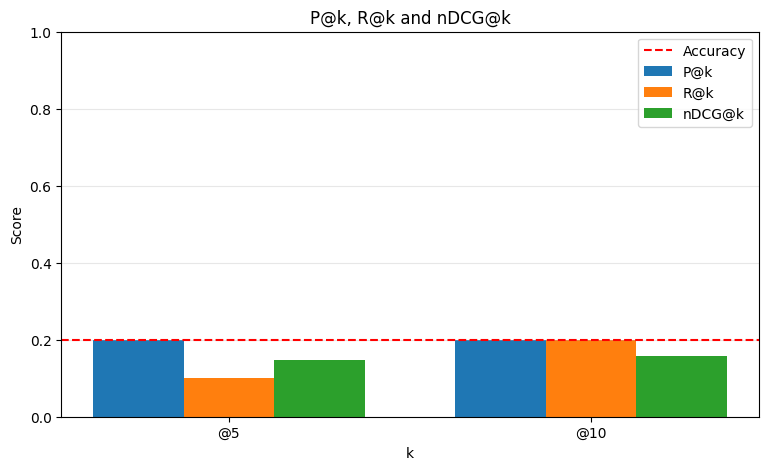

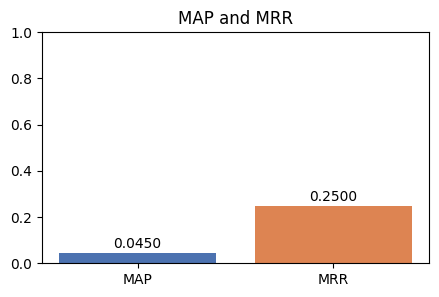

Numeric results:
P@5: 0.2000  R@5: 0.1000  nDCG@5: 0.1461 Accuracy: 0.2000 F1: 0.0000
P@10: 0.2000  R@10: 0.2000  nDCG@10: 0.1584 Accuracy: 0.2000 F1: 0.0000
MAP: 0.0450  MRR: 0.2500


In [27]:
# Plot evaluation results (P@k, R@k, nDCG@k, MAP, MRR)
import matplotlib.pyplot as plt

# Ensure evaluation data exists
try:
    # If evaluate_all was run earlier we may already have a results dict; otherwise compute now
    if 'y_true' in globals() and 'y_pred' in globals():
        results = evaluate_all([y_true], [y_pred], ks=[5,10])
    else:
        raise NameError('y_true or y_pred not found - run the rerank/evaluation cell first')
except Exception as e:
    print('Error preparing evaluation metrics:', e)
    raise

# Collect ks present in results (P@k keys)
ks = sorted([int(k.split('@')[1]) for k in results.keys() if k.startswith('P@') and k.split('@')[1].isdigit()])

p_vals = [results.get(f'P@{k}', 0.0) for k in ks]
r_vals = [results.get(f'R@{k}', 0.0) for k in ks]
ndcg_vals = [results.get(f'nDCG@{k}', 0.0) for k in ks]

# MAP and MRR
map_val = results.get('MAP', results.get('MAP', 0.0))
mrr_val = results.get('MRR', results.get('MRR', 0.0))
accuracy_val = results.get('Accuracy', results.get('Accuracy', 0.0))
f1_val = results.get('F1', results.get('F1', 0.0))

# Plot P@k, R@k, nDCG@k grouped
x = range(len(ks))
width = 0.25
plt.figure(figsize=(9,5))
plt.bar([i - width for i in x], p_vals, width=width, label='P@k')
plt.bar(x, r_vals, width=width, label='R@k')
plt.bar([i + width for i in x], ndcg_vals, width=width, label='nDCG@k')
plt.axhline(y=accuracy_val, color='r', linestyle='--', label='Accuracy')
plt.xticks(x, [f'@{k}' for k in ks])
plt.ylim(0, 1)
plt.xlabel('k')
plt.ylabel('Score')
plt.title('P@k, R@k and nDCG@k')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Plot MAP and MRR
plt.figure(figsize=(5,3))
plt.bar(['MAP','MRR'], [map_val, mrr_val], color=['#4c72b0','#dd8452'])
plt.ylim(0,1)
plt.title('MAP and MRR')
for i, v in enumerate([map_val, mrr_val]):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
plt.show()

# Print numeric results
print('Numeric results:')
for k in ks:
    print(f'P@{k}: {p_vals[ks.index(k)]:.4f}  R@{k}: {r_vals[ks.index(k)]:.4f}  nDCG@{k}: {ndcg_vals[ks.index(k)]:.4f} Accuracy: {accuracy_val:.4f} F1: {f1_val:.4f}')
print(f'MAP: {map_val:.4f}  MRR: {mrr_val:.4f}')
